# Automated Diagnosis Model

In this notebook I will be training a model on [medical X-Ray dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) from [Kaggle](https://www.kaggle.com/) to detect if the patient has Pneumonia or not. I will be using Inception V3 model as a base to train this new dataset. 

In [3]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


I'll start by mounting my drive so I can import my data sets

In [5]:
TRAIN_DIR='/Users/saniyanafees/Desktop/ML/transfer-learning/chest_xray/chest_xray/train/'
TEST_DIR='/Users/saniyanafees/Desktop/ML/transfer-learning/chest_xray/chest_xray/test/'


In [6]:
print('TRAIN DIR: ', os.listdir(TRAIN_DIR))
print('TEST DIR: ', os.listdir(TEST_DIR))


TRAIN DIR:  ['.DS_Store', 'PNEUMONIA', 'NORMAL']
TEST DIR:  ['.DS_Store', 'PNEUMONIA', 'NORMAL']


**Since we don't need the .DS_Store file, we're going to remove it and then continue to analyzing the dataset**

In [7]:
os.remove(TRAIN_DIR+'.DS_Store')
os.remove(TEST_DIR+'.DS_Store')
print('TRAIN DIR: ', os.listdir(TRAIN_DIR))
print('TEST DIR: ', os.listdir(TEST_DIR))

TRAIN DIR:  ['PNEUMONIA', 'NORMAL']
TEST DIR:  ['PNEUMONIA', 'NORMAL']


## Data Preprocessing

We'll begin by adding labels to the training and testing datasets.

In [8]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
      if nextDir in ['NORMAL']:
          label = 0
      elif nextDir in ['PNEUMONIA']:
          label = 1
      else:
          label = 2

      temp = Dir + nextDir

      for file in tqdm(os.listdir(temp)):
          img = cv2.imread(temp + '/' + file)
          if img is not None:
              img = skimage.transform.resize(img, (150, 150, 3))
              img = np.asarray(img)
              X.append(img)
              y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
  

In [9]:
X_train, y_train = get_data(TRAIN_DIR)


100%|██████████| 1342/1342 [08:18<00:00,  2.69it/s]


In [10]:
X_test , y_test = get_data(TEST_DIR)


100%|██████████| 234/234 [01:43<00:00,  2.27it/s]


## Data Visualization
Now let's look at a couple of images before we continue to train our model via transfer learning

-------------------- Normal -------------------- Pneumonia --------------------


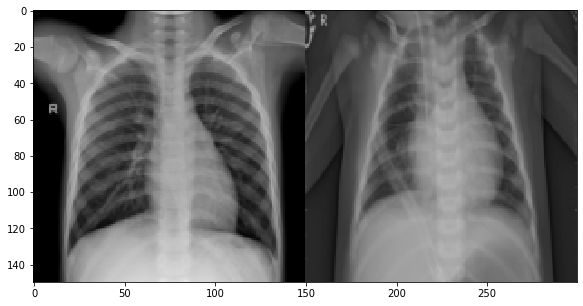

-------------------- Normal -------------------- Pneumonia --------------------


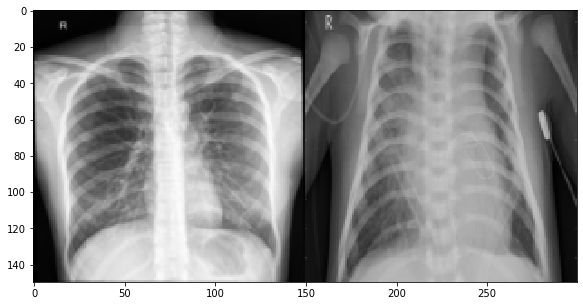

-------------------- Normal -------------------- Pneumonia --------------------


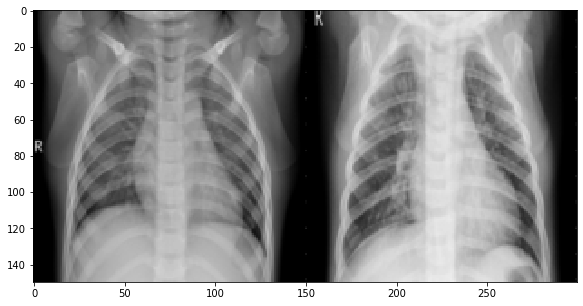

In [12]:
import matplotlib.pyplot as plt

PI=os.listdir('/Users/saniyanafees/Desktop/ML/transfer-learning/chest_xray/chest_xray/train/PNEUMONIA/')
NI=os.listdir('/Users/saniyanafees/Desktop/ML/transfer-learning/chest_xray/chest_xray/train/NORMAL/')

def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"/PNEUMONIA/"+PI[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"/NORMAL/"+NI[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print('-'*20,'Normal','-'*20,'Pneumonia','-'*20)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(20,23):
    plotter(i)
    

## Training
Now begins the fun part, transfer learning!! we'll be using InceptionV3 model, as mentioned earlier

In [34]:
from keras import backend as K
K.set_session

<function keras.backend.tensorflow_backend.set_session(session)>

In [52]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.tensorflow_backend.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [37]:
print('X_TRAIN: ', X_train.shape)
print('X_TEST: ', X_test.shape)
print('Y_TRAIN: ', y_train.shape)
print('Y_TEST: ', y_test.shape)

X_TRAIN:  (5216, 150, 150, 3)
X_TEST:  (624, 150, 150, 3)
Y_TRAIN:  (5216,)
Y_TEST:  (624,)


In [38]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


In [45]:
print('X_TRAIN: ', X_train.shape)
print('X_TEST: ', X_test.shape)
print('Y_TRAIN: ', y_train.shape)
print('Y_TEST: ', y_test.shape)

X_TRAIN:  (5216, 150, 150, 3)
X_TEST:  (624, 150, 150, 3)
Y_TRAIN:  (5216, 2)
Y_TEST:  (624, 2)


In [47]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False , input_shape=(150, 150,3))
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])




87916544/87910968 [==============================] - 7s 0us/step


In [48]:
batch_size = 64
epochs = 10


In [53]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 551s 106ms/step - loss: 0.0590 - accuracy: 0.9787 - val_loss: 0.3818 - val_accuracy: 0.9054

Epoch 00001: val_accuracy improved from -inf to 0.90545, saving model to transferlearning_weights.hdf5
Epoch 2/10
5216/5216 [==============================] - 558s 107ms/step - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.4819 - val_accuracy: 0.8750

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_accuracy did not improve from 0.90545
Epoch 3/10
5216/5216 [==============================] - 550s 105ms/step - loss: 0.0136 - accuracy: 0.9962 - val_loss: 0.7062 - val_accuracy: 0.8109

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_accuracy did not improve from 0.90545
Epoch 4/10
5216/5216 [==============================] - 578s 111ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.6726 - va

## Visualizing our results
Now let's look at our newly trained model's accuracy!

In [54]:
model.load_weights("/Users/saniyanafees/Desktop/ML/transfer-learning/transferlearning_weights.hdf5")

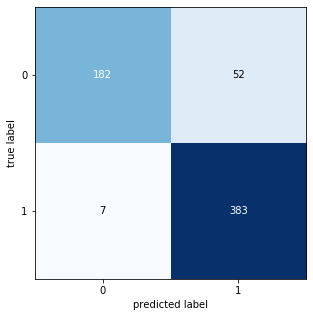

In [57]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

CM = confusion_matrix(y_true, pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [59]:
print(383/(383+52)*100,'%')

88.04597701149424 %


In [60]:
print(182/(182+7)*100,'%')

96.29629629629629 %


## Results
We have a precision of 88% and recall of 96%!